# Understanding Hodgkin-Huxley Model

###### Imports

In [6]:
# Custom Modules
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('__file__'), '..')))
from modules.hh_model import HodgkinHuxleyNeuron
from concept.hh_model import HodgkinHuxleyNeuron as NoJitHodgkinHuxleyNeuron

# Standard Modules
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Numba
from numba import njit, float64
from numba.experimental import jitclass
from numba.typed import List as NumbaList
import time as tm

import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline

###### Post-Synaptic Function

In [7]:
def I_postsyn(cur_V, par_V):
    weight = 0.1
    tau = 30
    I_syn = weight * np.exp(-(cur_V - par_V) / tau)
    return I_syn

## Single Neuron

In [8]:
T = 20
dt = 0.001
time = np.arange(0, T, dt)
weight = 0.1
tau = 30
I_inp = np.zeros(len(time))
I_inp[int(0.5/dt):int(1.0/dt)] = 15.0
V_record = []
I_out = np.zeros(len(time))


start  = tm.time()
neuron = HodgkinHuxleyNeuron(dt)
for i in range(len(time)):
    neuron.step(I_inp[i])
    V_record.append(neuron.V)
    I_out[i] = weight * np.exp(-(-65.0 - neuron.V) / tau)

end = tm.time()
jit_time = end - start


V_record = []
I_out = np.zeros(len(time))
start  = tm.time()
neuron = NoJitHodgkinHuxleyNeuron(dt)
for i in range(len(time)):
    neuron.step(I_inp[i])
    V_record.append(neuron.V)
    I_out[i] = weight * np.exp(-(-65.0 - neuron.V) / tau)

end = tm.time()
no_jit_time = end - start
print(f"JIT Execution Time: {jit_time} seconds")
print(f"No JIT Execution Time: {no_jit_time} seconds")
print(f"Speedup: {round(no_jit_time / jit_time, 2)}")

JIT Execution Time: 0.05204176902770996 seconds
No JIT Execution Time: 0.7289440631866455 seconds
Speedup: 14.01


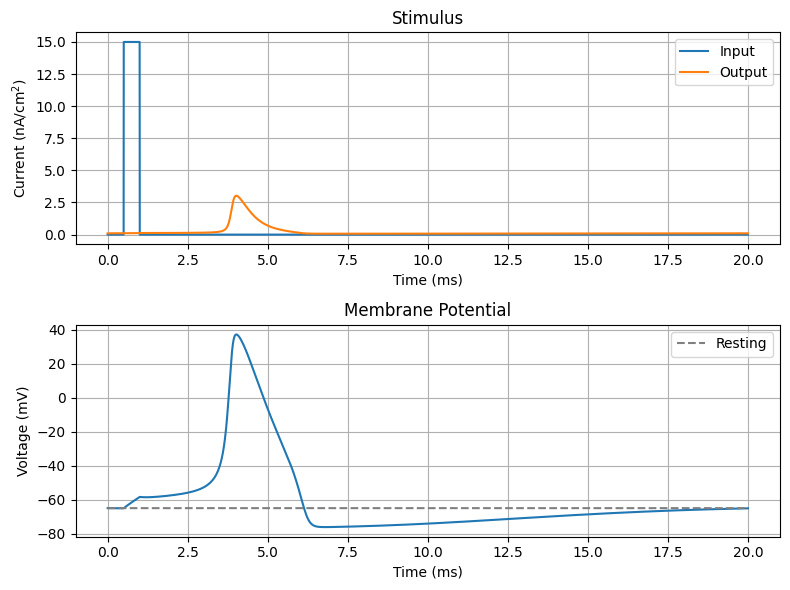

In [9]:
# Plot
plt.figure(figsize=(8, 6))
    
# Membrane potential V
plt.subplot(2, 1, 2)
plt.plot(time, V_record)
plt.plot(time, np.full(len(time), -65), linestyle='--', color='gray', label='Resting')
plt.title('Membrane Potential')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.grid()
plt.legend()

# Currents
plt.subplot(2, 1, 1)
plt.plot(time, I_inp, label='Input')
plt.plot(time, I_out, label='Output')
plt.title('Stimulus')
plt.xlabel('Time (ms)')
plt.ylabel('Current (nA/cm$^2$)')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

## Dynamics in neurons

In [10]:
def create_N_to_1(N):
    Network = {}

    # Dictionary of nodes
    nodes = {f'g{i}': HodgkinHuxleyNeuron() for i in range(N)}

    # Predecessors dictionary
    Adj = {f'g{i}': [f'g{0}'] for i in range(1, N)}
    
    Network['nodes'] = nodes
    Network['pred'] = Adj

    return Network


Net = create_N_to_1(3)
print(Net['nodes'])
print(Net['pred'])

TypeError: missing a required argument: 'step'

##### Simulation

In [ ]:
@njit
def sim(network):
    nodes = network['nodes']
    pred_dict = network['pred']
    N = len(nodes)

    V_record = {'g' + str(i): [] for i in range(len(Net['nodes']))}
    for i in range(len(step)):

        for j in range(N):
            neuron = nodes[j]
            I_temp = 0.0

            if j == 0:
                neuron.step(dt, I_inp[i])
                V_record['g' + str(j)].append(neuron.V)
            else:
                predecessors = pred_dict['g' + str(j)]

                for pred in predecessors:
                    parent = nodes[j]
                    I_temp += I_postsyn(neuron.V, parent.V)
        
                neuron.step(dt, I_temp)
                V_record['g' + str(j)].append(neuron.V)

    return V_record


def plot_sim(Vs, ax):
    for node, V in Vs.items():
        ax.plot(step, V, label=f'Neuron {node}')

    ax.plot(step, np.full(len(step), -65.0), linestyle='--', label='Resting', color='gray')  
    ax.set_title("Membrane Potential")
    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("Voltage (mV)")
    ax.grid()
    ax.legend()


Vs = sim(Net)
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
plot_sim(Vs, ax)

## Multiple Neurons

In [ ]:
NetA = create_N_to_1(4)
NetB = create_N_to_1(5)

fig, axes = plt.subplots(1, 2, figsize=(6, 3))
plot_network(NetA, axes[0])
plot_network(NetB, axes[1])

##### Simulation

In [ ]:
VsA = sim(NetA)
VsB = sim(NetB)

# Plot
plt.figure(figsize=(8, 6))

# Currents
plt.subplot(2, 1, 1)
plt.plot(step, I_inp, label='Input')
plt.plot(step, I_out, label='Output')
plt.title('Stimulus')
plt.xlabel('Time (ms)')
plt.ylabel('Current (nA/cm$^2$)')
plt.legend()
plt.grid()

# Membrane potential V
plt.subplot(2, 1, 2)
plt.plot(step, V_record)
plt.plot(step, np.full(len(step), -65.0),
         linestyle='--', color='gray', label='Resting')
plt.title('Membrane Potential')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
plot_sim(VsA, axes[0])
plot_sim(VsB, axes[1])

##### Cycles

In [ ]:
network = nx.DiGraph()
network.add_nodes_from(range(3))

network.add_edge(0, 1)
network.add_edge(1, 2)
network.add_edge(2, 0)

for node in network.nodes():
    network.nodes[node]['neuron'] = HodgkinHuxleyNeuron()

fig, axes = plt.subplots(1, 2, figsize=(8, 6))



V_record = {node: [] for node in network.nodes()}
Network = network.nodes()

for i, t in enumerate(step):
    for node in Network:
        neuron = Network[node]['neuron']
        I_temp = 0.0

        if node == 0:
            neuron.step(dt, I_inp[i])
            V_record[node].append(neuron.V)
        else:
            for pred in list(network.predecessors(node)):
                parent = Network[pred]['neuron']
                I_temp += I_postsyn(neuron.V, parent.V)
    
            neuron.step(dt, I_temp)
            V_record[node].append(neuron.V)


plot_network(network, axes[0])
plot_sim(V_record, axes[1])

##